# Explore here

In [4]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold

# Set random seed for notebook
random_seed=42

# Set train-test split fraction
testing_fraction=0.33

# Cross-validation method
cv_method=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_seed)

# Class weighting for decision trees
class_weights=None

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_df.drop_duplicates().reset_index(drop=True, inplace=True)
    

### train test split

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing, setting the random seed
# so that we get the same test-train split every time we run the notebook
training_df, testing_df=train_test_split(
    data_df,
    test_size=testing_fraction,
    random_state=random_seed
)

# Reset the indexes
training_df.reset_index(inplace=True, drop=True)
testing_df.reset_index(inplace=True, drop=True)

In [6]:
# Get features and labels
training_labels=training_df['Outcome']
training_features=training_df.drop('Outcome', axis=1)

In [7]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               514 non-null    int64  
 1   Glucose                   514 non-null    int64  
 2   BloodPressure             514 non-null    int64  
 3   SkinThickness             514 non-null    int64  
 4   Insulin                   514 non-null    int64  
 5   BMI                       514 non-null    float64
 6   DiabetesPedigreeFunction  514 non-null    float64
 7   Age                       514 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 32.2 KB


In [8]:
training_labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 514 entries, 0 to 513
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
514 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [9]:
list(training_labels[:10])

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

### Baseline DT Classifier

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments={'Baseline': scores * 100}

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.4%



Model is 100.0% accurate on the training data
Fitted tree depth: 11

Feature importances:
 Pregnancies: 0.059
 Glucose: 0.362
 BloodPressure: 0.074
 SkinThickness: 0.061
 Insulin: 0.040
 BMI: 0.168
 DiabetesPedigreeFunction: 0.105
 Age: 0.131



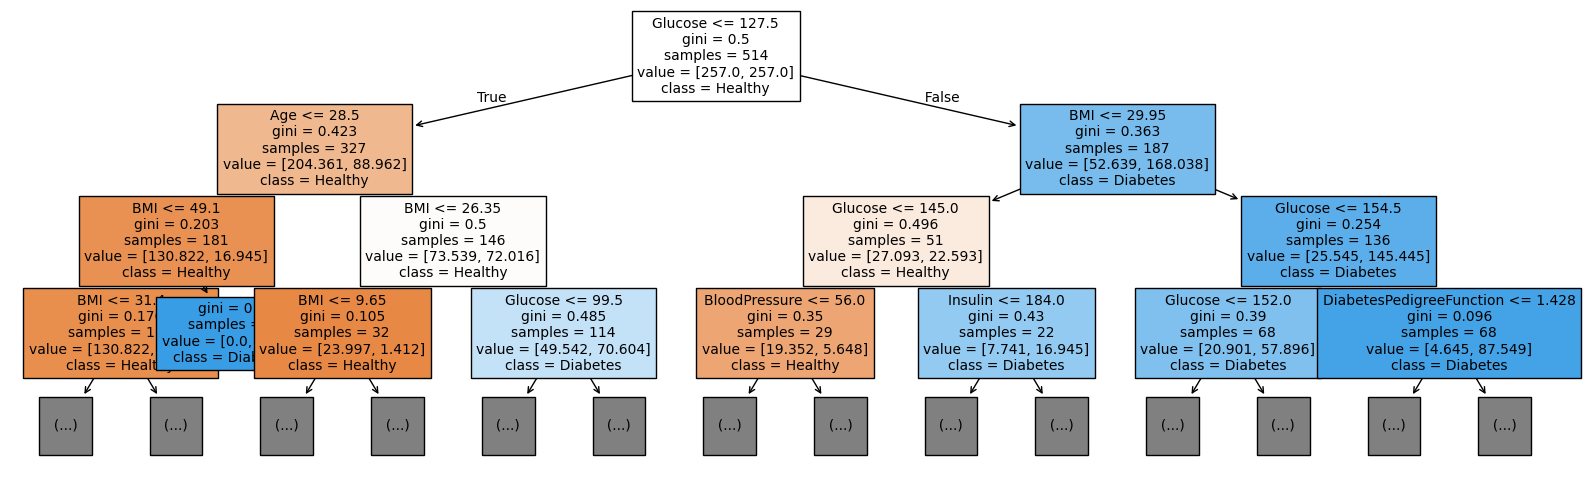

In [11]:
# Let's take a look at the tree
import matplotlib.pyplot as plt
from sklearn import tree

model=DecisionTreeClassifier(random_state=random_seed, class_weight='balanced')
fit_result=model.fit(training_features, training_labels)

# Make predictions from test set features
predicted_labels=model.predict(training_features)

# Score predictions for accuracy
percent_accuracy=accuracy_score(training_labels, predicted_labels) * 100

# Show some details about the model
print(f'\nModel is {percent_accuracy:.1f}% accurate on the training data')
print(f'Fitted tree depth: {fit_result.tree_.max_depth}')
print('\nFeature importances:')

for feature, importance in zip(training_features.columns, fit_result.tree_.compute_feature_importances()):
    print(f' {feature}: {importance:.3f}')

print()

# Plot the first few levels of the tree
fig=plt.figure(figsize=(20,6))

tree.plot_tree(model,
    feature_names=list(training_features.columns),
    class_names=['Healthy', 'Diabetes'],
    filled=True,
    fontsize=10,
     max_depth=3
)

plt.show()

### EDA/feature engineering

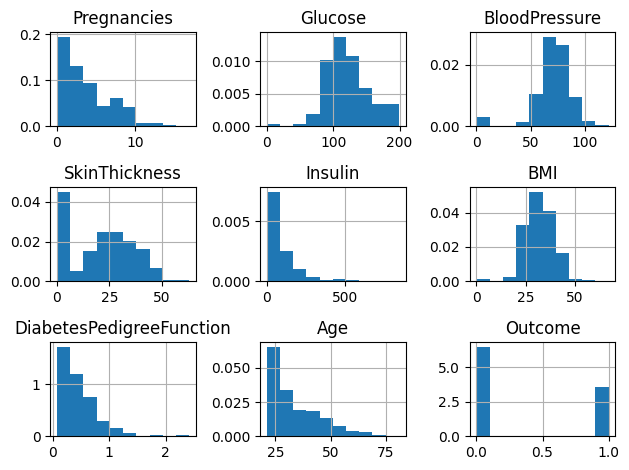

In [12]:
training_df.hist(density=True, layout=(3,3))
plt.tight_layout()
plt.show()

In [13]:
training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,3.782101,121.295720,69.984436,20.525292,79.237354,31.969844,0.473089,33.190661,0.354086
std,3.277187,32.358526,18.008763,15.501504,115.642548,7.649192,0.341989,11.731010,0.478701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,26.925000,0.244250,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,34.000000,32.000000,0.383500,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,125.750000,36.500000,0.614500,41.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
dead_people=len(training_df[training_df['BloodPressure'] == 0])
print(f'Have {dead_people} people with a blood pressure of 0')

Have 18 people with a blood pressure of 0


In [15]:
# Features to look for zeros in
missing_data_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Remove rows that have at least one zeros, using a copy, in case we decide it's a bad idea
filtered_training_df=training_df.copy()
filtered_training_df[missing_data_features]=filtered_training_df[missing_data_features].replace({0:np.nan})
filtered_training_df.dropna(inplace=True)

filtered_training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,3.335878,124.019084,70.847328,28.904580,155.110687,32.856870,0.511737,30.832061,0.332061
std,3.124764,30.748074,12.670885,10.626832,120.283283,7.188289,0.349665,10.129546,0.471854
min,0.000000,56.000000,24.000000,10.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,100.000000,62.500000,21.000000,79.000000,27.500000,0.273000,23.000000,0.000000
50%,2.000000,120.000000,70.000000,28.500000,125.000000,32.800000,0.443500,27.000000,0.000000
75%,5.000000,143.000000,80.000000,36.000000,182.750000,37.175000,0.653000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [16]:
simple_imputed_training_features=training_features.copy()

for target_feature in missing_data_features:

    impute_data=simple_imputed_training_features[simple_imputed_training_features[target_feature] != 0][target_feature]
    target_feature_imputed_value=impute_data.median()
    imputed_data=simple_imputed_training_features[target_feature].replace({0:target_feature_imputed_value})
    simple_imputed_training_features[target_feature]=imputed_data

    print(f'{target_feature} imputed value: {target_feature_imputed_value:.1f}')

simple_imputed_training_features.describe()

Glucose imputed value: 118.0
BloodPressure imputed value: 72.0
SkinThickness imputed value: 29.0
Insulin imputed value: 125.0
BMI imputed value: 32.0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,3.782101,122.214008,72.505837,28.762646,140.278210,32.281128,0.473089,33.190661
std,3.277187,30.522048,12.092761,8.535335,87.135766,6.960701,0.341989,11.731010
min,0.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,24.000000,120.000000,27.125000,0.244250,24.000000
50%,3.000000,118.000000,72.000000,29.000000,125.000000,32.000000,0.383500,29.000000
75%,6.000000,140.000000,80.000000,32.000000,125.750000,36.500000,0.614500,41.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


In [17]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    simple_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Simple imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.5%


### .2.2. Scikit-learn IterativeImputer


In [27]:
from notebook_helper_functions import impute

iterative_imputed_training_features, imp, qt=impute(training_features, missing_data_features)

[IterativeImputer] Completing matrix with shape (514, 8)
[IterativeImputer] Completing matrix with shape (514, 8)
New feature names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_indicator', 'BloodPressure_indicator', 'SkinThickness_indicator', 'Insulin_indicator', 'BMI_indicator']


In [28]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    iterative_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.8 +/- 3.5%


Have 8 features for plot:
 0: Pregnancies
 1: Glucose
 2: BloodPressure
 3: SkinThickness
 4: Insulin
 5: BMI
 6: DiabetesPedigreeFunction
 7: Age


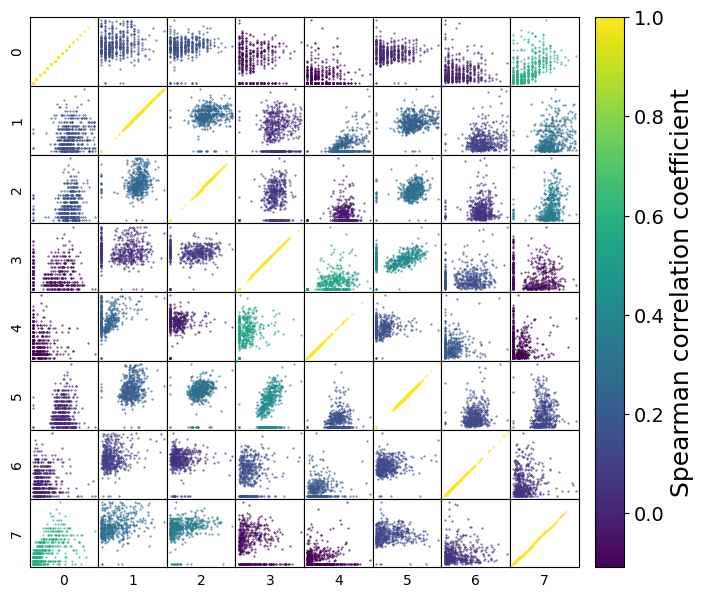

In [29]:
from notebook_helper_functions import plot_scatter_matrix

plot_scatter_matrix(training_features).show()

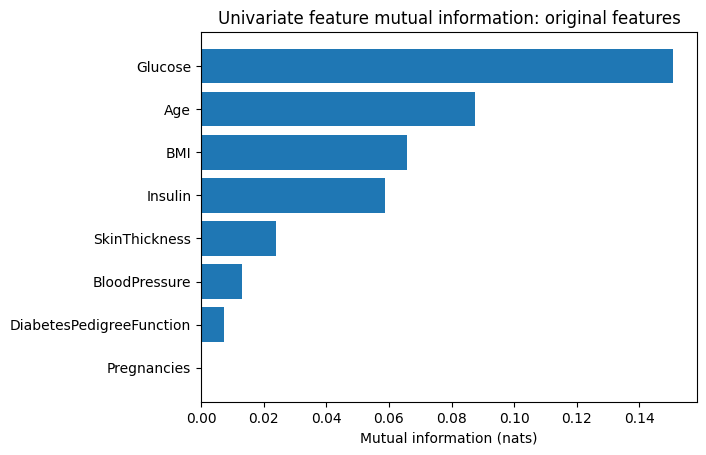

In [30]:
from sklearn.feature_selection import mutual_info_classif

results=mutual_info_classif(training_features, training_labels)

univariate_mi_results={}

for feature, result in zip(training_features.columns, results):
    univariate_mi_results[feature]=result

univariate_mi_results=dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: original features')

plt.barh(
    np.arange(len(univariate_mi_results.values())),
    univariate_mi_results.values(),
    tick_label=list(univariate_mi_results.keys())
)

plt.xlabel('Mutual information (nats)')

plt.show()

In [31]:
# Base on the plots above, let's try using the following features
manually_selected_feature_names=['Glucose','Insulin','BMI','Age']
manually_selected_training_features=training_features[manually_selected_feature_names]

In [32]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    manually_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Manual feature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.9 +/- 3.6%


### 2.4. Automated feature selection

In [33]:
from sklearn.feature_selection import RFECV

min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv=RFECV(
    estimator=model,
    step=1,
    cv=cv_method,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)

rfecv.fit(training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 8


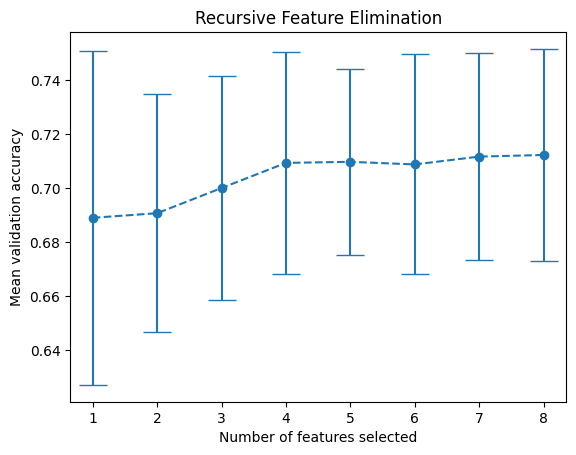

In [34]:
import matplotlib.pyplot as plt

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean validation accuracy')
plt.errorbar(
    x=cv_results['n_features'],
    y=cv_results['mean_test_score'],
    yerr=cv_results['std_test_score'],
    capsize=10,
    marker='o',
    linestyle='dashed'
)
plt.title('Recursive Feature Elimination')
plt.show()


In [35]:
automatically_selected_training_features=training_features.to_numpy()
automatically_selected_training_features=automatically_selected_training_features[:,rfecv.get_support()]

automatically_selected_feature_names=[b for a, b in zip(rfecv.get_support(), training_features.columns) if a]
automatically_selected_training_features=pd.DataFrame(data=automatically_selected_training_features, columns=automatically_selected_feature_names)
automatically_selected_training_features.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,10.0,115.0,98.0,0.0,0.0,24.0,1.022,34.0
1,7.0,142.0,60.0,33.0,190.0,28.8,0.687,61.0
2,4.0,116.0,72.0,12.0,87.0,22.1,0.463,37.0
3,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0
4,3.0,78.0,70.0,0.0,0.0,32.5,0.270,39.0


In [36]:
automatically_selected_training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               514 non-null    float64
 1   Glucose                   514 non-null    float64
 2   BloodPressure             514 non-null    float64
 3   SkinThickness             514 non-null    float64
 4   Insulin                   514 non-null    float64
 5   BMI                       514 non-null    float64
 6   DiabetesPedigreeFunction  514 non-null    float64
 7   Age                       514 non-null    float64
dtypes: float64(8)
memory usage: 32.2 KB


In [37]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    automatically_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Automatic feature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.4%


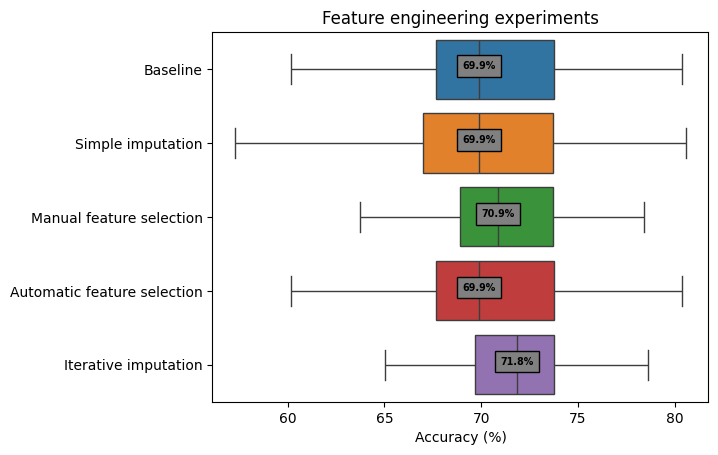

In [38]:
from notebook_helper_functions import plot_cross_validation

plot_cross_validation('Feature engineering experiments', experiments).show()


### 2.6. Follow-up experiments

In [39]:
from sklearn.feature_selection import RFECV

min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv=RFECV(
    estimator=model,
    step=1,
    cv=cv_method,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)

rfecv.fit(iterative_imputed_training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 13


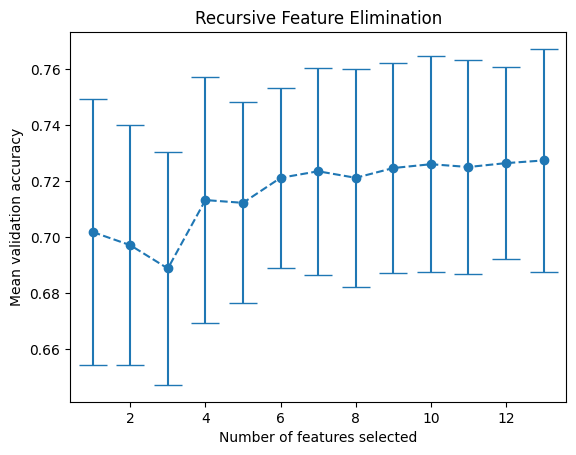

In [40]:
import matplotlib.pyplot as plt

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean validation accuracy')
plt.errorbar(
    x=cv_results['n_features'],
    y=cv_results['mean_test_score'],
    yerr=cv_results['std_test_score'],
    capsize=10,
    marker='o',
    linestyle='dashed'
)
plt.title('Recursive Feature Elimination')
plt.show()

In [41]:
automatically_selected_imputed_training_features=iterative_imputed_training_features.to_numpy()
automatically_selected_imputed_training_features=automatically_selected_imputed_training_features[:,rfecv.get_support()]

automatically_selected_imputed_feature_names=[b for a, b in zip(rfecv.get_support(), iterative_imputed_training_features.columns) if a]
automatically_selected_imputed_training_features=pd.DataFrame(data=automatically_selected_imputed_training_features, columns=automatically_selected_imputed_feature_names)
automatically_selected_imputed_training_features.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Glucose_indicator,BloodPressure_indicator,SkinThickness_indicator,Insulin_indicator,BMI_indicator
0,10.0,115.0,98.0,19.000000,97.410285,24.0,1.022,34.0,0.0,0.0,1.0,1.0,0.0
1,7.0,142.0,60.0,33.000000,190.000000,28.8,0.687,61.0,0.0,0.0,0.0,0.0,0.0
2,4.0,116.0,72.0,12.000000,87.000000,22.1,0.463,37.0,0.0,0.0,0.0,0.0,0.0
3,1.0,126.0,60.0,19.000000,291.482317,30.1,0.349,47.0,0.0,0.0,1.0,1.0,0.0
4,3.0,78.0,70.0,34.915352,52.733833,32.5,0.270,39.0,0.0,0.0,1.0,1.0,0.0


In [42]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    automatically_selected_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation,\nfeature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.8 +/- 3.5%


In [43]:
# First we need a new missing data features list that contains only
# missing data features which were selected by the recursive feature elimination
automatically_selected_missing_data_features=[]

for feature in missing_data_features:
    if feature in automatically_selected_training_features.columns:
        automatically_selected_missing_data_features.append(feature)

imputed_automatically_selected_training_features, automatically_selected_features_imp, automatically_selected_features_qt=impute(automatically_selected_training_features, automatically_selected_missing_data_features)

[IterativeImputer] Completing matrix with shape (514, 8)
[IterativeImputer] Completing matrix with shape (514, 8)
New feature names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_indicator', 'BloodPressure_indicator', 'SkinThickness_indicator', 'Insulin_indicator', 'BMI_indicator']


In [44]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_automatically_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Feature selection,\niterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.9 +/- 4.9%


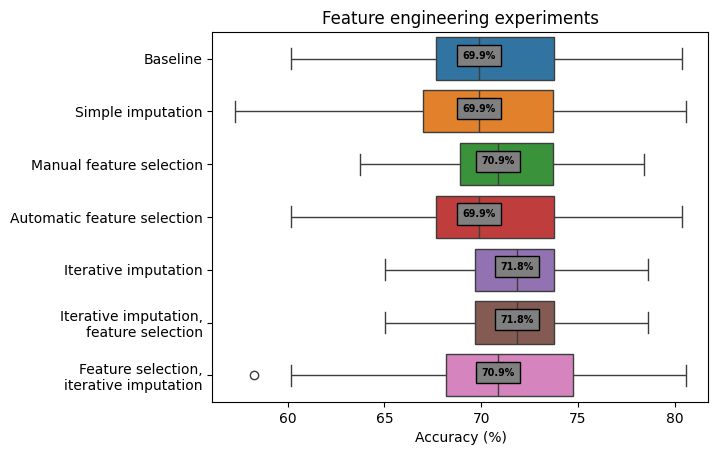

In [45]:
plot_cross_validation('Feature engineering experiments', experiments).show()

In [46]:
# Pick the feature set we want to use for hyperparameter tuning
hyperparameter_tuning_features=iterative_imputed_training_features[manually_selected_feature_names]
hyperparameter_tuning_features.head()

,Glucose,Insulin,BMI,Age
0,115.0,97.410285,24.0,34.0
1,142.0,190.000000,28.8,61.0
2,116.0,87.000000,22.1,37.0
3,126.0,291.482317,30.1,47.0
4,78.0,52.733833,32.5,39.0


### 3. Hyperparameter optimization

In [47]:
# Start new results holder for hyperparameter optimization results
hyperparameter_experiments={
    'Baseline': experiments['Baseline'],
    'Iterative imputation,\nfeature selection': experiments['Iterative imputation,\nfeature selection']
}

In [48]:
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV

model=DecisionTreeClassifier(random_state=random_seed)

distributions={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

grid=GridSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    return_train_score=True
)

results=grid.fit(hyperparameter_tuning_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'splitter': 'best'}


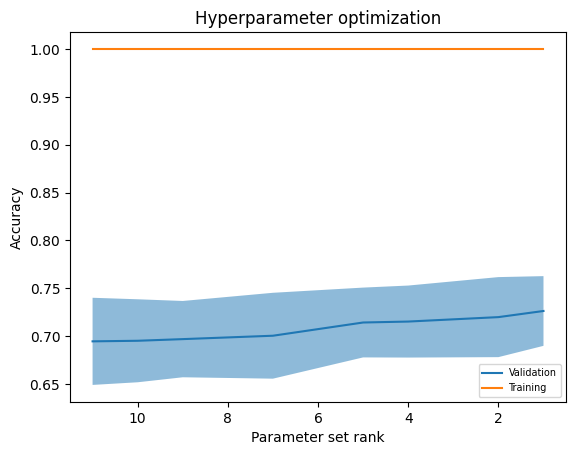

In [49]:
from notebook_helper_functions import plot_hyperparameter_tuning

plot_hyperparameter_tuning(results).show()

In [50]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    class_weight=results.best_params_['class_weight'],
    criterion=results.best_params_['criterion'],
    splitter=results.best_params_['splitter'],
    random_state=random_seed
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    hyperparameter_tuning_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 1']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 72.8 +/- 3.6%


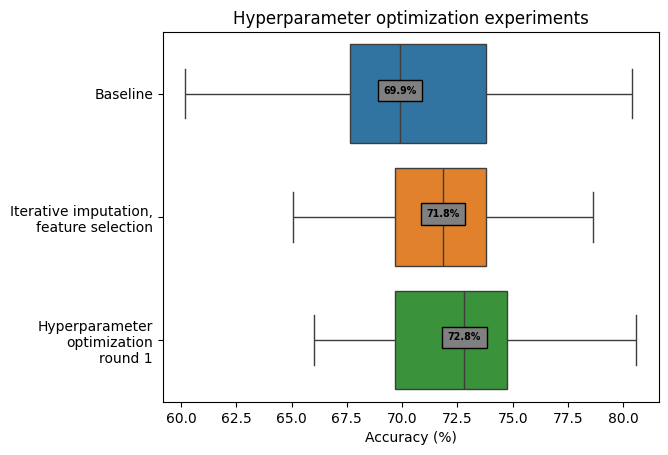

In [51]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

In [52]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

model=DecisionTreeClassifier(random_state=random_seed)

distributions={
    'max_depth': list(range(1, 50)),
    'min_samples_split': list(range(5, 50)),
    'min_samples_leaf': list(range(5, 50)),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_features': uniform(loc=0, scale=1),
    'min_impurity_decrease': uniform(loc=0, scale=1)
}

grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    n_iter=500,
    random_state=random_seed,
    return_train_score=True
)

results=grid.fit(hyperparameter_tuning_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'max_depth': 2, 'max_features': np.float64(0.9994137257706666), 'min_impurity_decrease': np.float64(0.04821203886055603), 'min_samples_leaf': 13, 'min_samples_split': 37, 'min_weight_fraction_leaf': np.float64(0.2034539803614353)}


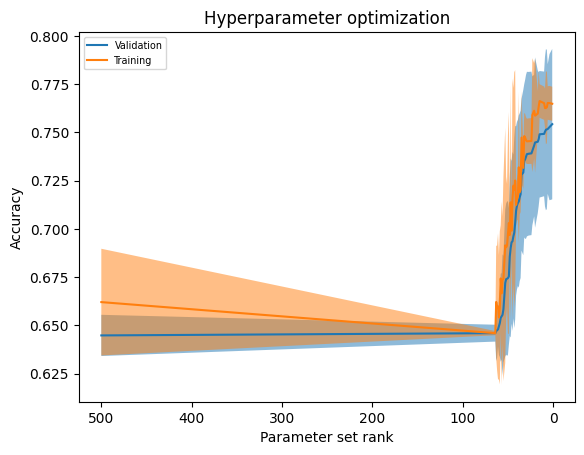

In [53]:
plot_hyperparameter_tuning(results).show()

In [54]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    max_depth=results.best_params_['max_depth'],
    max_features=results.best_params_['max_features'],
    min_impurity_decrease=results.best_params_['min_impurity_decrease'],
    min_samples_leaf=results.best_params_['min_samples_leaf'],
    min_samples_split=results.best_params_['min_samples_split'],
    min_weight_fraction_leaf=results.best_params_['min_weight_fraction_leaf'],
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    hyperparameter_tuning_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 2']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 75.7 +/- 5.1%


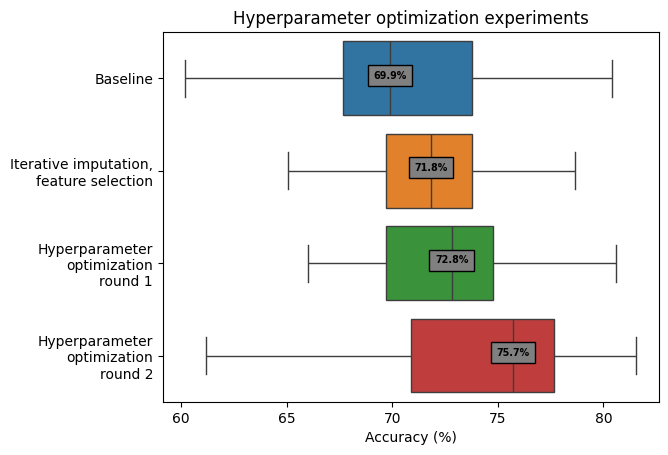

In [55]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

In [56]:
# Finally, fit the model on all of the training data at once
fit_result=model.fit(hyperparameter_tuning_features, training_labels)

### 4. Evaluation

In [57]:
# Get features and labels
testing_labels=testing_df['Outcome']
testing_features=testing_df.drop('Outcome', axis=1)

In [58]:
# Use the quantile transformer and imputer that we fit on the training data to transform the testing data

# Save the feature names for later - the imputer will return a numpy array
# and we might like to get out Pandas dataframe back
feature_names=list(testing_features.columns)

# Make a copy of the testing features
imputed_testing_features=testing_features.copy()
imputed_testing_features[missing_data_features]=imputed_testing_features[missing_data_features].replace({0:np.nan})

# Quantile transform our features - this is for the imputer, not the decision tree
imputed_testing_features[missing_data_features]=qt.transform(imputed_testing_features[missing_data_features])

# Run the imputation
imputed_testing_features=imp.transform(imputed_testing_features)

# Convert back to pandas
indicator_features=[]
for feature in missing_data_features:
    indicator_features.append(f'{feature}_indicator')

feature_names.extend(indicator_features)
imputed_testing_features=pd.DataFrame(data=imputed_testing_features, columns=feature_names)

# Now that zeros have been replaces - undo the quantile transformation.
# This way we are training the model on un-altered values. This way,
# during deployment, we don't have to worry about transforming the input data.
imputed_testing_features[missing_data_features]=qt.inverse_transform(imputed_testing_features[missing_data_features])
imputed_testing_features.head()

[IterativeImputer] Completing matrix with shape (254, 8)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Glucose_indicator,BloodPressure_indicator,SkinThickness_indicator,Insulin_indicator,BMI_indicator
0,6.0,98.0,58.0,33.000000,190.000000,34.0,0.430,43.0,0.0,0.0,0.0,0.0,0.0
1,2.0,112.0,75.0,32.000000,146.584269,35.7,0.148,21.0,0.0,0.0,0.0,1.0,0.0
2,2.0,108.0,64.0,29.000000,484.893056,30.8,0.158,21.0,0.0,0.0,1.0,1.0,0.0
3,8.0,107.0,80.0,16.418747,89.075500,24.6,0.856,34.0,0.0,0.0,1.0,1.0,0.0
4,7.0,136.0,90.0,18.000000,185.422933,29.9,0.210,50.0,0.0,0.0,1.0,1.0,0.0


In [59]:
# Get only the selected features from the testing data, using the list
# determined during the feature selection on the training data
selected_imputed_testing_features=imputed_testing_features[manually_selected_feature_names]
selected_imputed_testing_features.head()

,Glucose,Insulin,BMI,Age
0,98.0,190.000000,34.0,43.0
1,112.0,146.584269,35.7,21.0
2,108.0,484.893056,30.8,21.0
3,107.0,89.075500,24.6,34.0
4,136.0,185.422933,29.9,50.0


In [60]:
# Make predictions from test set features
predicted_labels=model.predict(selected_imputed_testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 72.0% accurate on the test data


In [61]:
# Save the model
model_output_file='../models/model.pkl'

with open(model_output_file, 'wb') as output_file:
    pickle.dump(model, output_file, protocol=pickle.HIGHEST_PROTOCOL)

# Save the quantile transformer
quantile_transformer_output_file='../models/quantile_transformer.pkl'

with open(quantile_transformer_output_file, 'wb') as output_file:
    pickle.dump(qt, output_file, protocol=pickle.HIGHEST_PROTOCOL)

# Save the imputation model
imputer_output_file='../models/imputer.pkl'

with open(imputer_output_file, 'wb') as output_file:
    pickle.dump(imp, output_file, protocol=pickle.HIGHEST_PROTOCOL)